![8th International Summer School on Computational Interaction](imgs/header.png)

# 2: Exercise
**John H. Williamson**

In the exercise, we will experiment with both **forward** and **backward** models. We'll have the live link to the keyboard fist sensor, and you'll be able to test different approaches to interpreting the sensor vector.

We'll work in groups for this exercise.

## Task
You have two parts:

* 2(a) Implement/tune the direct inverse model, using the skeleton and instruction below
* 2(b) Implement/tune the Bayesian inverse model, using the skeleton and instruction below
* TRY THESE MODELS WITH MORE CHALLENGING SENSING CONDITIONS -- see below!

## FAQ

* I can't run the keyboard model! 
    * Check if the `sudo` option helps (needed on Linux). If not, find someone else who can run the demo!
* I can run the keyboard model, but it doesn't connect to the machine learning!
    * This is probably a firewall issue on your laptop. You need to allow port 5556 for localhost traffic.
* The predictions are too good even with a simple model!
    * Make sure you are making the problem hard enough -- see the model variations below!
* The predictions are bad!
    * Yes, the default settings are not especially optimal. Also, these are simplified models to not make your life too complicated.
* I don't have a group.
    * Find a couple of neighbours and form groups of 2-4.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Global imports (remember to run this cell!)
import sys

sys.path = ["src"] + sys.path
from flax import linen as nn
from flax.training import train_state
import optax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from zmqutils import safe_launch
from sklearn.model_selection import train_test_split
import jax
import pfilter
from key_model import multi_simulate
from zmqutils import sync_rep_loop


# utils...
def prediction_loop(predict_fn, port=5556):
    # synchronous reply loop -- receive touch events and reply with predictions
    def loop_fn(touch_input):
        # respond to touch events
        if "touch" in touch_input:
            # decode it, predict and send a response
            x = np.array(touch_input["touch"]).astype(np.float32).reshape(1, 270)
            seq = touch_input["seq"]
            y = predict_fn(x)
            msg = {
                "target": {
                    "x": float(y[0, 0]),
                    "y": float(y[0, 1]),
                    "radius": float(y[0, 2]),
                },
                "seq": seq,
            }
            print(f"{seq}                     \r", end="")
            return msg
        # queue shutdown
        if "quit" in touch_input:
            raise StopIteration

    sync_rep_loop(port, loop_fn)


def offset_plot(true, predicted):
    # plot lines between the predicted and actual points
    fig, ax = plt.subplots(figsize=(15, 4.5))
    ax.scatter(true[:, 0], true[:, 1], label="Actual", marker="x")
    predictions = mlp_state.apply_fn(mlp_state.params, X_test)
    ax.scatter(predicted[:, 0], predicted[:, 1], label="Predicted", marker="o")
    for i in range(len(y_test)):
        ax.plot(
            [true[i, 0], predicted[i, 0]],
            [true[i, 1], predicted[i, 1]],
            color="black",
            alpha=0.1,
        )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()

## Variations of the sensor configuration
You can make the problem more or less hard by changing the configuration of `key_demo`. 

You'll find the direct inverse is worse at coping with noise or dropped frames than the Bayesian inverse model, so do try the simulator with different settings.

Here are some options you can pass to `key_demo.py`
* `--noise` adds noise to the sensor data. 0.1 is a lot.
* `--frame_drop` drops this fraction of frames entirely
* `--position_drift` adds positional wobble to the sensor data (0.03 is a lot)
* `--intensity_std` adds noise to the overall gain (0.5 is a lot)

Here are some examples (uncomment and try some):

In [ ]:
safe_launch("src/key_demo.py", args=["--zmq_port", "5556"], timeout=0, sudo=True) # normal

In [ ]:
# CTRL-ESC to exit!
safe_launch("src/key_demo.py", args=["--zmq_port", "5556", "--noise", "0.1"], timeout=0, sudo=True) # noisy
#safe_launch("src/key_demo.py", 
#            args=["--zmq_port", "5556", 
#                  "--frame_drop", "0.1"], timeout=0) # intermittent frame drop
# safe_launch("src/key_demo.py", args=["--zmq_port", "5556", "--position_drift", "0.02"], timeout=0) # warbling position
# safe_launch("src/key_demo.py", args=["--zmq_port", "5556", "--noise", "0.1",
#                                      "--frame_drop", "0.1", "--position_drift", "0.02",
#                                       "--intensity_std","0.3"],
#              timeout=0) # many things at once!

# 2 (a) Direct inverse model
The code below allows you to train and test a direct inverse model. 

**Things you can do:**
* Capture more or new data from the live capture; (you could merge multiple CSV files just by concatenating them, if you want to do this as a group)
* Capture data from the **simulator**. You can configure the number of frames to simulate and the parameters of the simulator.
* Change the hyperparameters of the model (e.g. learning rate, iterations, etc.) and the loss function
* Adjust the network itself (e.g. change the number of layers, activations, size of layers, use convolutional layers, etc.)

You can then run the model live against the touch simulator and see how well it works :)

### 2(a) Data capture

You can either use my original data (`data/clean.csv`) or generate your own data using the following code.  

To generate data:
* uncomment the `safe_launch` line below. 
* The keyboard interface will appear
* Press your fist somewhere!
* Click with the mouse on the centre point of the target
* Keep doing this until you are bored.
* Press `CTRL-ESC` to quit the capture
* Note: calling `safe_launch` will append to the data file each time it is called. Use `--overwrite` to force it to be rewritten.

In [ ]:
# Manual data generation

# add "--overwrite" to the arguments if you want to overwrite the file
safe_launch("src/key_demo.py", args=["--file", "data/my_fistpointer_data.csv"], timeout=1000, sudo=True)
# data_file = "data/my_fistpointer_data.csv" # your data

Or, you can use the simulator to generate new data (it will also append to any existing data file):

In [ ]:
# Simulated data generation

from key_model import batch_simulate

# you can modify these parameters; noise, size and intensity are most relevant
simulator_params = {
    "out_file": "data/sim_data.csv",  # output file
    "n": 1000,  # number of samples
    "x_sampler": lambda: np.random.uniform(0, 1),  # x coordinate sampling
    "y_sampler": lambda: np.random.uniform(0, 1),  # y coordinate sampling
    "size_sampler": lambda: np.random.uniform(0.02, 0.05),  # size sampling
    "intensity_sampler": lambda: np.random.uniform(0.8, 2),  # intensity sampling
    "noise": 0.001,  # noise level
}

# leave size and slc as they are
# uncomment to run the simulation
batch_simulate(size=32, slc=[9,30], **simulator_params)

Wrote 1000 samples to data/sim_data.csv


In [12]:
# SET THE DATA FILE TO THE DATA YOU WANT TO USE HERE
data_file = "data/clean.csv"  # my data at the moment

In [13]:
# Data preprocessing -- you shouldn't need to change this cell
data = np.loadtxt(data_file, delimiter=",").astype(np.float32)
print(f"Read data with shape {data.shape} from {data_file}")

# split the features from the targets
data_features, data_targets = data[:, :-2], data[:, -2:]

# split into test and train
X_train, X_test, y_train, y_test = train_test_split(
    data_features, data_targets, test_size=0.2, random_state=42
)
print(f"Training data has {len(X_train)} samples, test data has {len(X_test)} samples")
assert X_train.shape[1] == 270 and y_train.shape[1] == 2, "Data has the wrong shape"
assert X_test.shape[1] == 270 and y_test.shape[1] == 2, "Data has the wrong shape"
print("Data read and split successfully")

Read data with shape (77, 272) from data/clean.csv
Training data has 61 samples, test data has 16 samples
Data read and split successfully


### 2(a) Parameters
You can vary the settings below to change the training and testing behaviour.

In [18]:
### CHANGE ME ###

# Hyperparameters for training
direct_params = {
    "learning_rate": 0.001,
    "iterations": 10000,
    "batch_size": 32,
}

# Define the loss function (MSE)
# You can change this if you wish!
def mse_loss(predictions, targets):
    return jnp.mean((predictions - targets) ** 2)

# Define the MLP model
class MLP(nn.Module):
    # 270 - 32 -> 2 dimensions
    @nn.compact
    def __call__(self, x):
        # x will be a (batch, 270) element tensor
        x = nn.Dense(features=32)(x)
        x = nn.swish(x)
        x = nn.Dense(features=2)(x)  # Output layer with 2 dimensions
        return x

### 2(a) Training
You don't need to modify the cell below usually. You can run it to train the model.

In [19]:
# Leave this cell as it is, unless you are doing something clever!
# Define a function to create the train state
def create_MLP(rng, learning_rate):
    model = MLP()
    params = model.init(rng, jnp.ones((1, 270)))
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


# Define the evaluation function (for testing)
def evaluate(state, batch):
    predictions = state.apply_fn(state.params, batch["inputs"])
    loss = mse_loss(predictions, batch["targets"])
    return loss


# predict an output from a single
def predict(state, single_input):
    single_input = single_input.reshape(
        1, -1
    )  # Ensure the input has the shape (1, 270)
    prediction = state.apply_fn(state.params, single_input)
    return prediction


# One training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        predictions = state.apply_fn(params, batch["inputs"])
        loss = mse_loss(predictions, batch["targets"])
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


# Train the model
rng = jax.random.PRNGKey(42)
learning_rate = direct_params["learning_rate"]
mlp_state = create_MLP(rng, learning_rate)
batch = {"inputs": X_train, "targets": y_train}

# train loop
for i in range(direct_params["iterations"]):
    mlp_state, loss = train_step(mlp_state, batch)
    if i % 100 == 0:
        print(f"Step {i}, Loss {loss}")

Step 0, Loss 0.3680678606033325
Step 100, Loss 0.008638267405331135
Step 200, Loss 0.0027266074903309345
Step 300, Loss 0.000996788963675499
Step 400, Loss 0.0004149287415202707
Step 500, Loss 0.00018537530559115112
Step 600, Loss 8.594230166636407e-05
Step 700, Loss 4.04869242629502e-05
Step 800, Loss 1.9085542589891702e-05
Step 900, Loss 8.922411325329449e-06
Step 1000, Loss 4.124195129406871e-06
Step 1100, Loss 1.881731691355526e-06
Step 1200, Loss 8.432865570284775e-07
Step 1300, Loss 3.6808847880820394e-07
Step 1400, Loss 1.5505088413192425e-07
Step 1500, Loss 6.253673490164147e-08
Step 1600, Loss 2.4011587385075472e-08
Step 1700, Loss 8.742099488756594e-09
Step 1800, Loss 3.0104603254699214e-09
Step 1900, Loss 9.790499522210894e-10
Step 2000, Loss 3.007090132456369e-10
Step 2100, Loss 8.726586814278292e-11
Step 2200, Loss 2.3918424532642923e-11
Step 2300, Loss 6.24960326545132e-12
Step 2400, Loss 1.5755082785270935e-12
Step 2500, Loss 4.008259924057761e-13
Step 2600, Loss 1.09218

### 2(a) Offline testing
The tests below will give you some idea of how well your model works (but no substitute for live testing!).


In [ ]:
# Evaluate the model, and plot some examples
test_batch = {"inputs": X_test, "targets": y_test}
test_loss = evaluate(mlp_state, test_batch)
print(f"Test loss: {test_loss:.4f}")

predicted = mlp_state.apply_fn(mlp_state.params, X_test)
offset_plot(y_test, predicted)

### 2(a) Live testing

The code below will allow you to test your model live against the simulator. Remember to try it in different conditions, not just the default noise level! What works well? What is hard to fix by improving the model? 

In [ ]:
# CTRL-ESC to exit! -- you can add additional params to change noise etc. here
# safe_launch("src/key_demo.py", args=["--zmq_port", "5556"], timeout=0, sudo=True)

safe_launch("src/key_demo.py", args=["--zmq_port", "5556",
                                     "--noise", "0.2"],
            timeout=0, sudo=True)

def ml_predict(y):
    x = np.array(y).astype(np.float32).reshape(1, 270)
    y = predict(mlp_state, x)
    y = np.concatenate([y, np.array([[0.005]])], axis=1)  # add fixed radius
    return y


prediction_loop(ml_predict, port=5556)

----

# 2 (b) Bayesian inversion with a particle filter
Now, you can try and tune the particle filter for the same task. Note the completely different way this works -- there's no training data at all!


**Things you can do:**
* Change the hyperparameters (e.g. number of particles, prior sampling proportion)
* Adjust the likelihood function (e.g. tweak the tolerance of the similarity kernel, replace it with something else)
* Adjust the dynamics model (e.g. increase variance of the dynamics, or change the dynamics model entirely)
* **very ambitious** fuse the direct inverse in 2(a) with 2(b) to get a better estimate of the touch location

### 2(b) Parameters
You can vary the parameters below to change the behaviour of the particle filter. `tolerance` and `dt` are particularly useful.

In [22]:
pf_params = {
    "n_particles": 100,  # number of particles
    "resample_proportion": 0.02,
    "dt": 0.1,  # time step size; larger means "faster" dynamics
    "pos_std": 0.5,  # standard deviation of position noise
    "vel_std": 0.05,  # standard deviation of velocity noise
    "acc_std": 0.05,  # standard deviation of acceleration noise
    "tolerance": 0.3,  # similarity tolerance for observation likelihood (smaller = less tolerant)
    "z_scale": 0.01,  # effect of fist height on fist size
    "z_bias": 0.03,  # offset (zero value) for size
}

### 2(b) Definition
The code below should work without modification. It defines the particle filter.

In [23]:
# You don't need to change this cell
physical_units = np.array([9 / 30, 1, 1])  # account for *physical* units
dt = pf_params["dt"]


def prior_fn(n):
    prior = np.zeros((n, 9))  # pos, vel, acc
    prior[:, :3] = np.random.uniform(-0.1, 1.1, (n, 3))  # pos (x,y,z)
    prior[:, 3:6] = np.random.normal(0, 0.1, (n, 3))  # vel (dx, dy, dz)
    prior[:, 6:9] = np.random.normal(0, 0.01, (n, 3))  # acc (ddx, ddy, ddz)
    return prior


def deterministic_dynamics_fn(state):
    # apply very simple Euler time integration
    state[:, :3] += state[:, 3:6] * dt * physical_units  # vel -> pos
    state[:, 3:6] += state[:, 6:9] * dt * physical_units  # acc -> vel
    state[:, 3:6] *= 0.999  # damp velocity
    return state


def stochastic_dynamics_fn(state):
    noise = np.random.normal(0, 1, size=state.shape)
    v = pf_params["vel_std"]
    a = pf_params["acc_std"]
    p = pf_params["pos_std"]
    noise_scale = np.array([p, p, p, v, v, v, a, a, a]) * 0.01
    state += noise * noise_scale
    return state


def observe_fn(state):
    return multi_simulate(
        size=32,
        slc=[9, 30],
        xs=state[:, 0],
        ys=state[:, 1],
        intensities=1.5 + 0 * state[:, 0],
        sizes=pf_params["z_bias"] + pf_params["z_scale"] * state[:, 2],
        noise=0.0,
    )


def lik_fn(simulated, real):
    real = real.reshape(1, -1)
    simulated = simulated.reshape(len(simulated), -1)
    return np.exp(
        -np.sum((simulated - real) ** 2, axis=1) / pf_params["tolerance"] ** 2
    )


pf = pfilter.ParticleFilter(
    prior_fn,
    weight_fn=lik_fn,
    observe_fn=observe_fn,
    dynamics_fn=deterministic_dynamics_fn,
    noise_fn=stochastic_dynamics_fn,
    n_particles=pf_params["n_particles"],
    resample_proportion=pf_params["resample_proportion"],
)


def process_frame(pf, frame):
    if np.sum(frame) == 0:  # blank frame, update but don't correct
        pf.update(observed=None)
    else:
        pf.update(observed=frame)
    # convert samples into summary statistics
    mean = pf.mean_state[:2]
    radius = np.std(pf.original_particles[:,0])
    # same format as the direct inverse: x, y, r
    return np.array([[mean[0], mean[1], radius]])

### 2(b) Offline testing
This code just lets you test that nothing is broken. It will not give you a good idea of how well your model works.

Weights (should be [1.0, <1.0])
[1.00000000e+00 2.42098206e-59]


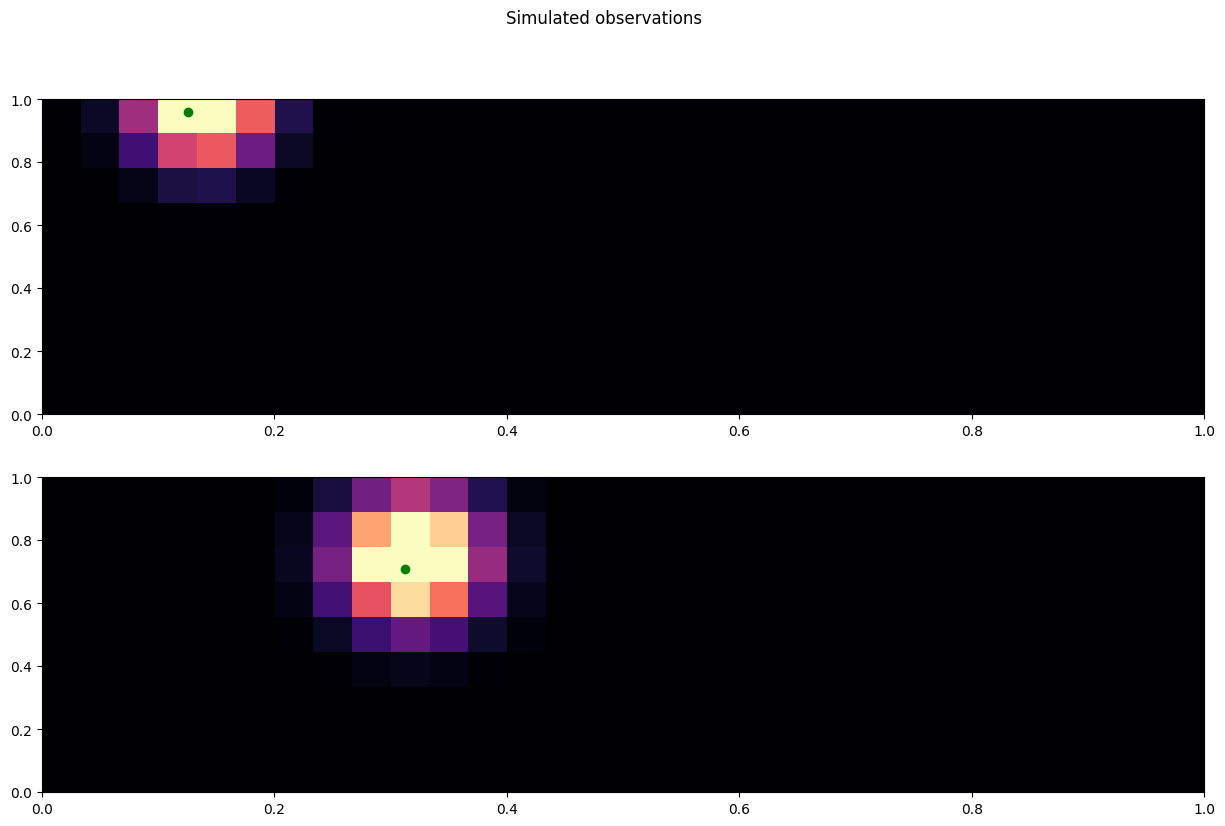

In [24]:
# First, sanity check the sampling!
samples = prior_fn(2)
samples = deterministic_dynamics_fn(samples)
samples = stochastic_dynamics_fn(samples)
observations = observe_fn(samples)
weights = lik_fn(observations, observations[0])
pf.update(None)  # test filter is working okay
pf.update(observed=observations[0])

fig, axs = plt.subplots(2, 1, figsize=(15, 9))
axs[0].imshow(
    observations[0],
    cmap="magma",
    aspect="auto",
    extent=[0, 1, 0, 1],
    vmin=0,
    vmax=1,
    origin="lower",
)
axs[1].imshow(
    observations[1],
    cmap="magma",
    aspect="auto",
    extent=[0, 1, 0, 1],
    vmin=0,
    vmax=1,
    origin="lower",
)
fig.suptitle("Simulated observations")
axs[0].scatter(samples[0, 0], samples[0, 1], color="green")
axs[1].scatter(samples[1, 0], samples[1, 1], color="green")

print("Weights (should be [1.0, <1.0])")
print(weights)

/var/folders/6y/fdf8wk_52jl4c5d2bnv27j240000gn/T/ipykernel_96871/914793278.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=1,


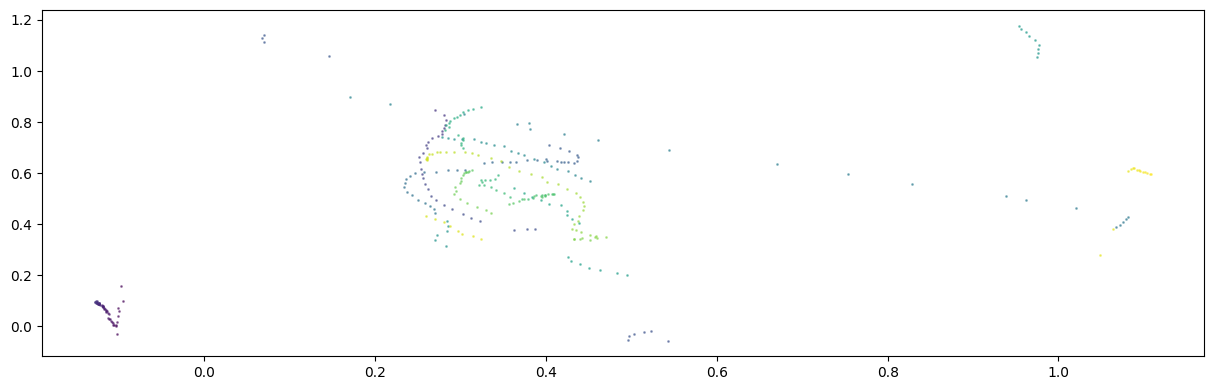

In [25]:
# Now run against an offline trace, and plot the results
# There is no ground truth here; this just gives you a 
# sense if the trajectories look like smooth-ish cycles.
test_trajectory = np.loadtxt("data/circle.csv", delimiter=",")

fig, ax = plt.subplots(figsize=(15, 4.5))
pf.init_filter()
for i, row in enumerate(test_trajectory):
    pf.update(row[:270].reshape(9,30))
    x, y = pf.mean_state[:2]
    ax.scatter(x, y, s=1, 
               alpha=0.5, c=plt.get_cmap('viridis')(i/len(test_trajectory)))
       

### 2(b) Live testing

Finally, live testing. Again, what works well here? What can't you easily fix by adapting the model? How does it compare to the direct inversion model?

In [ ]:
# CTRL-ESC to exit!
# safe_launch("src/key_demo.py", args=["--zmq_port", "5556"], timeout=0, sudo=True)
safe_launch("src/key_demo.py", args=["--zmq_port", "5556",
                                     "--noise", "0.2"], timeout=0, sudo=True)

# initialize the filter and create the prediction callback
pf.init_filter()
def pf_predict(y):
    x = np.array(y).astype(np.float32).reshape(9, 30)
    y = process_frame(pf, x)
    return y

# start predicting
prediction_loop(pf_predict, port=5556)

# 3 Report back

**MENTIMETER**: Put your comments on what you've found out.

# END OF EXERCISE
